In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from scipy.stats import norm
import math
import warnings
warnings.simplefilter('ignore', category=RuntimeWarning)
from scipy.special import beta
from decimal import *

In [2]:
class Agent:
  def __init__(self, E, arm_times, arm_random_p, arm_size):
    self.E = E
    self.arm_times = arm_times
    self.arm_random_p = arm_random_p
    self.arm_size = arm_size
  
  def initialize(self):
    self.E = np.array([0.5] * self.arm_size)
    self.arm_times = np.array([10**-7] * self.arm_size)
    self.arm_random_p = np.array([0] * self.arm_size)

  def updata(self, reward, action):
    self.arm_times[action] += 1

    #報酬
    a = 1/(self.arm_times[action]+1)
    self.E[action] = (1-a) * self.E[action] + a * reward

  def random_prob(self, size):
    self.arm_random = np.random.rand(size)
    return self.arm_random

  def reward(self, p, action):
    if random.random() < p[action]:
      return 1.0
    else:
      return 0.0    


class Agent_TS:
  def __init__(self, E, arm_times, arm_random_p, arm_size):
    self.E = E
    self.arm_times = arm_times
    self.arm_random_p = arm_random_p
    self.success = np.zeros(len(E))
    self.fail = np.zeros(len(E))
    self.arm_size = arm_size
  
  def initialize(self):
    self.E = np.array([0.5] * self.arm_size)
    self.arm_times = np.array([10**-7] * self.arm_size)
    self.arm_random_p = np.array([0] * self.arm_size)
    self.success = np.zeros(self.arm_size)
    self.fail = np.zeros(self.arm_size)

  def updata(self, reward, action):
    self.arm_times[action] += 1
    #報酬
    self.E[action] = ((self.arm_times[action]-1)/self.arm_times[action])*self.E[action] + (1/self.arm_times[action]) * reward
    if reward == 1:
      self.success[action] = self.success[action] +1
    elif reward == 0:
      self.fail[action] = self.fail[action] + 1

  def random_prob(self, size):
    self.arm_random = np.random.rand(size)
    return self.arm_random

  def reward(self, p, action):
    if random.random() < p[action]:
      return 1.0
    else:
      return 0.0    

In [3]:
######################################
class SRS:
  def __init__(self, p, epsilon):
    self.aleph = p.max()
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    if  E.max() > self.aleph:
      E = E - E.max() + self.aleph - self.epsilon

    Z = 1/(np.sum(1/(self.aleph - E)))
    row = Z / (self.aleph - E)

    b = (arm_times / row) - N + self.epsilon
    # b = (N * row - arm_times)/row

    SRS = (N + b.max()) * row - arm_times
    pi = SRS/np.sum(SRS)
    return np.random.choice(len(pi),p=pi)

######################################
class SRS_OPT:
  def __init__(self, p, epsilon):
    p = sorted(p,reverse=True)
    self.aleph = (p[0] + p[1])/2
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    if  E.max() > self.aleph:
      E = E - E.max() + self.aleph - self.epsilon

    Z = 1/(np.sum(1/(self.aleph - E)))
    row = Z / (self.aleph - E)

    b = (arm_times / row) - N + self.epsilon

    SRS = (N + b.max()) * row - arm_times

    pi = SRS/np.sum(SRS)
    return np.random.choice(len(pi),p=pi)

######################################
class RS:
  def __init__(self, p, epsilon):
    self.aleph = p.max()
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    RS = (arm_times / N)*(E - self.aleph)
    
    return np.argmax(RS)
######################################
class RS_OPT:
  def __init__(self, p, epsilon):
    p = sorted(p,reverse=True)
    self.aleph = (p[0] + p[1])/2
  
  def select_arm(self, E, arm_times, N, agent):
    RS = (arm_times / N)*(E - self.aleph)
    
    return np.argmax(RS)

######################################
class TS:
  def __init__(self, p, epsilon):
    self.p = p
  
  def select_arm(self, E, arm_times, N, agent):
    myu = np.array([np.random.beta(agent.success[action]+1, agent.fail[action]+1) for action in range(agent.arm_size)])
    return np.argmax(myu)

#######################################
class RS_CH_two:
  def __init__(self, p, epsilon):
    self.epsilon = epsilon
  
  def select_arm(self, E, arm_times, N, agent):
    E_max = E.max()
    Dkl  = E*np.log(E/E_max) + (1-E)*np.log((1-E)/(1-E_max))
    myu = np.exp((-1)*arm_times*Dkl)
    aleph = np.nan_to_num(E_max*((1-(E/E_max)*myu)/(1-myu)),nan=0)
    aleph_ch = max(aleph)

    RS = (arm_times/N)*(E - aleph_ch)
    return np.argmax(RS)

#######################################
class RS_CH_multi:
  def __init__(self, p, epsilon):
    self.epsilon = epsilon

  def DKL(self, p, q):
    return p*np.log(p/q) + (1-p)*np.log((1-p) / (1-q))
  
  def select_arm(self, E, arm_times, N, agent):
    E_max = E.max()
    greedy = random.choice(np.where(E==E.max())[0])

    Dkl  = self.DKL(E, E_max)
    myu = np.exp((-1)*arm_times*Dkl)
    myu[greedy] = 0
    aleph_ch = np.nan_to_num( E_max*( (1-( E/E_max )*myu )/( 1-myu )), nan=0)

    RS_index = np.where((arm_times/(N+1)) * (E - aleph_ch) >= (arm_times[greedy]/(N+1)) * (E[greedy] - aleph_ch))[0]
    if len(RS_index) < 2:
      return greedy
    else:
      myu_max = myu[RS_index].max()
      myu_index = np.where(myu == myu_max)[0]
      if len(myu_index) == 1:
        return  myu_index[0]
      else:
        aleph_max = aleph_ch[myu_index].max()
        aleph_index = np.where(aleph_ch == aleph_max)[0]
        return np.random.choice(aleph_index)

######################################
class SRS_CH:
  def __init__(self, p, epsilon):
    self.aleph = 1.0
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    E_max = E.max()
    Dkl  = E*np.log(E/E_max) + (1-E)*np.log((1-E)/(1-E_max))
    myu = np.exp((-1)*arm_times*Dkl)
    aleph = np.nan_to_num(E_max*((1-(E/E_max)*myu)/(1-myu)),nan=0)
    aleph_ch = max(aleph)

    if  E.max() > aleph_ch:
      E = E - E.max() + self.aleph - self.epsilon

    Z = 1/(np.sum(1/(aleph_ch - E)))
    row = Z / (aleph_ch - E)
    b = (arm_times / row) - N + self.epsilon

    SRS = (N + b.max()) * row - arm_times
    pi = SRS/np.sum(SRS)
    return np.random.choice(len(pi),p=pi)

#######################################
class SRS_CH_multi:
  def __init__(self, p, epsilon):
    self.epsilon = epsilon

  def DKL(self, p, q):
    return p*np.log(p/q) + (1-p)*np.log((1-p) / (1-q))
  
  def select_arm(self, E, arm_times, N, agent):
    E_max = E.max()
    Dkl  = self.DKL(E, E_max)
    myu = np.exp((-1)*arm_times*Dkl)
    aleph_ch = np.nan_to_num( E_max*( (1-( E/E_max )*myu )/( 1-myu )), nan=0)
    aleph_max = max(aleph_ch)

    greedy = random.choice(np.where(E==E.max())[0])
    myu[greedy] = 0

    if  E[greedy] > aleph_max:
      E = E - E[greedy] + aleph_max - self.epsilon

    Z = 1/(np.sum(1/(aleph_ch - E)))
    row = Z / (aleph_ch - E)
    b = (arm_times / row) - N + self.epsilon

    SRS = (N + b.max()) * row - arm_times
    pi = SRS/np.sum(SRS)
    pi_index = np.where((N + b.max()) * row - arm_times >= (N + b.max()) * row - arm_times[greedy])[0]
    
    if len(pi_index) < 2:
      return greedy
    else:
      myu_max = myu[pi_index].max()
      myu_index = np.where(myu == myu_max)[0]
      if len(myu_index) == 1:
        return  myu_index[0]
      else:
        aleph_max = aleph_ch[myu_index].max()
        aleph_index = np.where(aleph_ch == aleph_max)[0]
        return np.random.choice(aleph_index)

In [4]:
class Simulater:
  def __init__(self, n_sim, steps, arm_size, epsilon):
    self.steps = steps
    self.n_sim = n_sim
    self.arm_size = arm_size
    self.epsilon = epsilon
  
  def test(self, policy, Agent):
    agent = Agent(np.array([0.5]*self.arm_size), np.array([10**-7]*self.arm_size), np.zeros(self.arm_size), self.arm_size)
    regret = np.zeros((self.n_sim, self.steps))

    for sim in tqdm(range(self.n_sim)):
      p = agent.random_prob(self.arm_size)
      pi = policy(p, self.epsilon)
      for step in range(0, self.steps):
        action = pi.select_arm(agent.E, agent.arm_times, step+1, agent)
        reward = agent.reward(p,action)
        agent.updata(reward, action)
        regret[sim, step] += regret[sim, step-1] + np.max(p) - p[action]
      agent.initialize()
    return regret

100%|██████████| 100/100 [04:41<00:00,  2.81s/it]


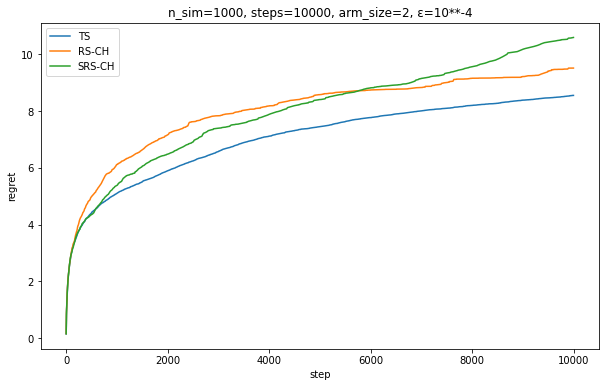

In [12]:
simulata = Simulater(n_sim=100, steps=10000, arm_size=2, epsilon=10**-4)

regret_RS_CH = simulata.test(RS_CH_two, Agent)
regret_SRS_CH = simulata.test(SRS_CH, Agent)
regret_TS = simulata.test(TS, Agent_TS)

plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("regret")

plt.plot(np.mean(regret_TS, axis=0), label="TS")
plt.plot(np.mean(regret_RS_CH, axis=0), label="RS-CH")
plt.plot(np.mean(regret_SRS_CH, axis=0), label="SRS-CH")

plt.title("n_sim=1000, steps=10000, arm_size=2, ε=10**-4")
plt.legend()
plt.show()